In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import numpy as np
import random
import os
import sys
import matplotlib.pyplot as plt

from CDlib import Dataloader

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", DEVICE)

Using device:  cuda


In [4]:
class BinaryChangeDetector(nn.Module):
    def __init__(self):
        super(BinaryChangeDetector, self).__init__()

        # siamese network for the two input images
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # layers after concatenation
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.out = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, img1, img2):
        # forward pass for the first image
        x1 = F.sigmoid(self.conv1(img1))
        x1 = F.sigmoid(self.conv2(x1))
        x1 = F.sigmoid(self.conv3(x1))

        # forward pass for the second image
        x2 = F.sigmoid(self.conv1(img2))
        x2 = F.sigmoid(self.conv2(x2))
        x2 = F.sigmoid(self.conv3(x2))

        # concatenate the two images
        x = torch.cat((x1, x2), 1)

        # forward pass after concatenation
        x = F.sigmoid(self.conv4(x))
        x = F.sigmoid(self.conv5(x))
        x = F.sigmoid(self.conv6(x))
        x = self.pool(x) 
        x = self.out(x)
        return x

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_label = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [6]:
SECOND_DATASET = Dataloader.BCD_DATALOADER(transform=transform, transform_label=transform_label)
data_loader = DataLoader(SECOND_DATASET, batch_size=1, shuffle=True)

In [7]:
test_image_T1, test_image_T2, test_label = SECOND_DATASET[0]
test_image_T1 = test_image_T1.unsqueeze(0)
test_image_T2 = test_image_T2.unsqueeze(0)
test_label = test_label.unsqueeze(0)

print(test_image_T1.shape, test_image_T2.shape, test_label.shape)

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])


In [8]:
model = BinaryChangeDetector()

y = model(test_image_T1, test_image_T2)
print(y.shape)

torch.Size([1, 1, 128, 128])


In [35]:
model = BinaryChangeDetector().to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    for i, (image_T1, image_T2, label) in enumerate(data_loader):
        image_T1 = image_T1.to(DEVICE)
        image_T2 = image_T2.to(DEVICE)
        label = label.to(DEVICE)

        optimizer.zero_grad()
        output = model(image_T1, image_T2)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item()}")


Epoch 0, Iteration 0, Loss: 0.7288205027580261
Epoch 0, Iteration 10, Loss: 0.697553813457489
Epoch 0, Iteration 20, Loss: 0.6686431765556335
Epoch 0, Iteration 30, Loss: 0.3972369134426117
Epoch 0, Iteration 40, Loss: 0.27028077840805054
Epoch 0, Iteration 50, Loss: 0.25667762756347656
Epoch 0, Iteration 60, Loss: 0.3966756761074066
Epoch 0, Iteration 70, Loss: 0.32199060916900635
Epoch 0, Iteration 80, Loss: 0.29746752977371216
Epoch 0, Iteration 90, Loss: 0.26080256700515747
Epoch 0, Iteration 100, Loss: 0.2587669789791107
Epoch 0, Iteration 110, Loss: 0.5568652153015137
Epoch 0, Iteration 120, Loss: 1.024786114692688
Epoch 0, Iteration 130, Loss: 0.5664620399475098
Epoch 0, Iteration 140, Loss: 0.8134281635284424
Epoch 0, Iteration 150, Loss: 0.7581262588500977
Epoch 0, Iteration 160, Loss: 0.44429466128349304
Epoch 0, Iteration 170, Loss: 0.4028656482696533
Epoch 0, Iteration 180, Loss: 0.26485675573349
Epoch 0, Iteration 190, Loss: 0.3194933235645294
Epoch 0, Iteration 200, Loss:

KeyboardInterrupt: 

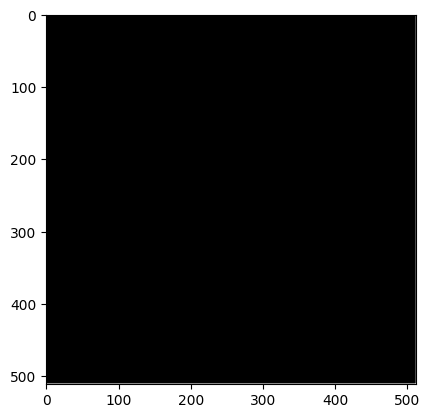

In [37]:
y = model(test_image_T1.to(DEVICE), test_image_T2.to(DEVICE))
plt.imshow(y[0, 0].detach().cpu().numpy(), cmap='gray')